# Object Detection using YOLOX with OpenVINO™

Welcome to this tutorial notebook that demonstrates the use of YOLOX with OpenVINO. YOLOX is a state-of-the-art object detection algorithm that achieves excellent accuracy while maintaining real-time performance. OpenVINO, on the other hand, is a powerful toolkit that optimizes the inference of deep learning models on a wide range of hardware platforms.

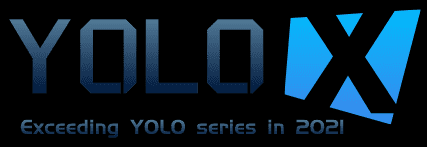

By combining the strengths of YOLOX and OpenVINO, you can get the best of both worlds: highly accurate object detection with lightning-fast inference on a variety of hardware devices. This tutorial will guide you through the process of using YOLOX with OpenVINO to detect objects in images and videos.

Whether you are a computer vision researcher, an engineer working on a product that requires object detection, or just an enthusiast interested in learning about the latest and greatest in computer vision, this tutorial will provide you with a solid foundation to get started with YOLOX and OpenVINO. So let's dive in and explore the exciting world of object detection with YOLOX and OpenVINO!

Implementation: https://github.com/Megvii-BaseDetection/YOLOX

## Prerequisites

In [39]:
# Import Libraries
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from openvino.inference_engine import IECore

sys.path.append("../utils")
import notebook_utils as utils
%matplotlib inline

## Downloading Models

Here is a table containing information about different YOLOX models and their corresponding pre-converted ONNX versions.

To download the ONNX version of a model, please copy the download link from the table and use it in the next cell(uncommenting it) to initiate the download process.

| Model | Parameters | GFLOPs | Test Size | mAP | Weights |
|:------| :----: | :----: | :---: | :---: | :---: |
|  YOLOX-Nano |  0.91M  | 1.08 | 416x416 | 25.8 |[github](https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_nano.onnx) |
|  YOLOX-Tiny | 5.06M     | 6.45 | 416x416 |32.8 | [github](https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_tiny.onnx) |
|  YOLOX-S | 9.0M | 26.8 | 640x640 |40.5 | [github](https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_s.onnx) |
|  YOLOX-M | 25.3M | 73.8 | 640x640 |47.2 | [github](https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_m.onnx) |
|  YOLOX-L | 54.2M | 155.6 | 640x640 |50.1 | [github](https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_l.onnx) |
|  YOLOX-Darknet53| 63.72M | 185.3 | 640x640 |48.0 | [github](https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_darknet.onnx) |
|  YOLOX-X | 99.1M | 281.9 | 640x640 |51.5 | [github](https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_x.onnx) |

In [40]:
# url = ""
# onnx_model = download_file(url)
# print(f'Downloaded file saved to {onnx_model}')

We are going to use the `YOLOX-nano` model, which is already downloaded with the repository.

In [41]:
onnx_model = "./yolox_nano.onnx"

# Test Image

Provide path to the image you want to test on.

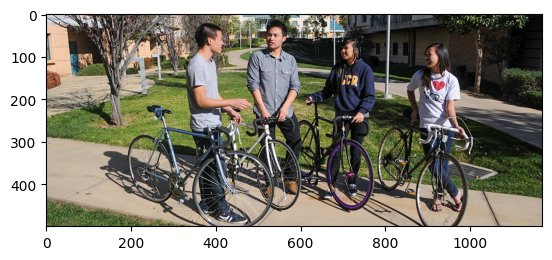

In [42]:
input_path = "input.jpg"
image = utils.load_image(input_path)
plt.imshow(image[:, :, ::-1])

# Utility Functions

In [19]:
# Colorsfor Boundng Boxes
_COLORS = np.array(
    [
        0.000, 0.447, 0.741,
        0.850, 0.325, 0.098,
        0.929, 0.694, 0.125,
        0.494, 0.184, 0.556,
        0.466, 0.674, 0.188,
        0.301, 0.745, 0.933,
        0.635, 0.078, 0.184,
        0.300, 0.300, 0.300,
        0.600, 0.600, 0.600,
        1.000, 0.000, 0.000,
        1.000, 0.500, 0.000,
        0.749, 0.749, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 1.000,
        0.667, 0.000, 1.000,
        0.333, 0.333, 0.000,
        0.333, 0.667, 0.000,
        0.333, 1.000, 0.000,
        0.667, 0.333, 0.000,
        0.667, 0.667, 0.000,
        0.667, 1.000, 0.000,
        1.000, 0.333, 0.000,
        1.000, 0.667, 0.000,
        1.000, 1.000, 0.000,
        0.000, 0.333, 0.500,
        0.000, 0.667, 0.500,
        0.000, 1.000, 0.500,
        0.333, 0.000, 0.500,
        0.333, 0.333, 0.500,
        0.333, 0.667, 0.500,
        0.333, 1.000, 0.500,
        0.667, 0.000, 0.500,
        0.667, 0.333, 0.500,
        0.667, 0.667, 0.500,
        0.667, 1.000, 0.500,
        1.000, 0.000, 0.500,
        1.000, 0.333, 0.500,
        1.000, 0.667, 0.500,
        1.000, 1.000, 0.500,
        0.000, 0.333, 1.000,
        0.000, 0.667, 1.000,
        0.000, 1.000, 1.000,
        0.333, 0.000, 1.000,
        0.333, 0.333, 1.000,
        0.333, 0.667, 1.000,
        0.333, 1.000, 1.000,
        0.667, 0.000, 1.000,
        0.667, 0.333, 1.000,
        0.667, 0.667, 1.000,
        0.667, 1.000, 1.000,
        1.000, 0.000, 1.000,
        1.000, 0.333, 1.000,
        1.000, 0.667, 1.000,
        0.333, 0.000, 0.000,
        0.500, 0.000, 0.000,
        0.667, 0.000, 0.000,
        0.833, 0.000, 0.000,
        1.000, 0.000, 0.000,
        0.000, 0.167, 0.000,
        0.000, 0.333, 0.000,
        0.000, 0.500, 0.000,
        0.000, 0.667, 0.000,
        0.000, 0.833, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 0.167,
        0.000, 0.000, 0.333,
        0.000, 0.000, 0.500,
        0.000, 0.000, 0.667,
        0.000, 0.000, 0.833,
        0.000, 0.000, 1.000,
        0.000, 0.000, 0.000,
        0.143, 0.143, 0.143,
        0.286, 0.286, 0.286,
        0.429, 0.429, 0.429,
        0.571, 0.571, 0.571,
        0.714, 0.714, 0.714,
        0.857, 0.857, 0.857,
        0.000, 0.447, 0.741,
        0.314, 0.717, 0.741,
        0.50, 0.5, 0
    ]
).astype(np.float32).reshape(-1, 3)

In [20]:
# Class Names for this model
COCO_CLASSES = (
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "backpack",
    "umbrella",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "dining table",
    "toilet",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
)

In [34]:
def preprocess(img, input_size, swap=(2, 0, 1)):
    """
    Preprocesses an image by resizing and padding it to a specific input size,
            and converting it to a float32 NumPy array.

    Args:
        img (numpy.ndarray): The image to preprocess.
        input_size (tuple): A tuple of two integers representing the desired
                            input size.
        swap (tuple, optional): A tuple of three integers representing the
                                desired order of color channels. Defaults
                                to (2, 0, 1).

    Returns:
        numpy.ndarray: The preprocessed image as a float32 NumPy array.
        float: The scaling ratio of the image.
    """

    # Check if image has 3 dimensions, otherwise pad it with 114
    if len(img.shape) == 3:
        padded_img = np.ones((input_size[0], input_size[1], 3),
                             dtype=np.uint8) * 114
    else:
        padded_img = np.ones(input_size, dtype=np.uint8) * 114

    # Resize the image and calculate the scaling ratio
    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img,
        (int(img.shape[1] * r), int(img.shape[0] * r)),
        interpolation=cv2.INTER_LINEAR,
    ).astype(np.uint8)

    # Copy the resized image into the padded image array
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    # Swap the color channels and convert the padded image array to a float32
    # NumPy array
    padded_img = padded_img.transpose(swap)
    padded_img = np.ascontiguousarray(padded_img, dtype=np.float32)
    return padded_img, r


def mkdir(path):
    """Create a new directory if it does not exist.

    Args:
        path (str): The path of the directory to create.

    Returns:
        None

    """
    # Check if the directory already exists
    if not os.path.exists(path):
        os.makedirs(path)


def nms(boxes, scores, nms_thr):
    """
    Apply Non-Maximum Suppression (NMS) to a set of bounding boxes, removing
        those that overlap with higher-scoring boxes.

    Args:
    boxes: Numpy array of shape (num_boxes, 4), containing the coordinates of
            each bounding box in (x1, y1, x2, y2) format.
    scores: Numpy array of shape (num_boxes,), containing the confidence scores
            of each bounding box.
    nms_thr: Float specifying the threshold for overlap between bounding boxes,
            above which the lower-scoring box will be removed.

    Returns:
    keep: List of indices corresponding to the bounding boxes that were
            retained after NMS.
    """
    # Extract coordinates of bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Calculate area of each bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Sort scores in descending order and get corresponding indices
    order = scores.argsort()[::-1]

    # Initialize list to store indices of boxes to keep
    keep = []

    # Loop over all boxes
    while order.size > 0:
        # Select box with highest score
        i = order[0]
        keep.append(i)

        # Calculate intersection between selected box and all other boxes
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        # Calculate overlap between selected box and all other boxes
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        # Keep only boxes with overlap less than NMS threshold
        inds = np.where(ovr <= nms_thr)[0]
        order = order[inds + 1]

    return keep


def multiclass_nms(boxes, scores, nms_thr, score_thr, class_agnostic=True):
    """
    Multiclass NMS implemented in Numpy.

    Args:
        boxes (numpy.ndarray): A numpy array of shape (N, 4) where N is the
                            number of bounding boxes, and the last dimension
                            represents (x1, y1, x2, y2) of each bounding box.
        scores (numpy.ndarray): A numpy array of shape (N, C) where N is the
                            number of bounding boxes, and C is the number of
                            classes. Each element represents the score of
                            each bounding box for each class.
        nms_thr (float): The IoU threshold used in non-maximum suppression.
        score_thr (float): The threshold used to filter out bounding boxes
                            with scores lower than this value.
        class_agnostic (bool): Whether to use class-agnostic NMS or class-aware
                            NMS. If True, class-agnostic NMS is used.

    Returns:
        numpy.ndarray: A numpy array of shape (M, 6) where M is the number of
                        final detections after NMS, and the last dimension
                        represents (x1, y1, x2, y2, score, class) of each
                        detection.
    """
    # Choose NMS method
    if class_agnostic:
        nms_method = multiclass_nms_class_agnostic
    else:
        nms_method = multiclass_nms_class_aware

    # Apply NMS
    return nms_method(boxes, scores, nms_thr, score_thr)


def multiclass_nms_class_aware(boxes, scores, nms_thr, score_thr):
    """
    Multiclass NMS implemented in Numpy. Class-aware version.

    Args:
        boxes (numpy.ndarray): A numpy array of shape (N, 4) where N is the
                            number of bounding boxes, and the last dimension
                            represents (x1, y1, x2, y2) of each bounding box.
        scores (numpy.ndarray): A numpy array of shape (N, C) where N is the
                            number of bounding boxes, and C is the number of
                            classes. Each element represents the score of
                            each bounding box for each class.
        nms_thr (float): The IoU threshold used in non-maximum suppression.
        score_thr (float): The threshold used to filter out bounding boxes
                            with scores lower than this value.

    Returns:
        numpy.ndarray: A numpy array of shape (M, 6) where M is the number
                    of final detections after NMS, and the last dimension
                    represents (x1, y1, x2, y2, score, class) of each
                    detection.
    """

    final_dets = []
    num_classes = scores.shape[1]

    # Iterate over all classes
    for cls_ind in range(num_classes):
        cls_scores = scores[:, cls_ind]
        valid_score_mask = cls_scores > score_thr

        # If no bounding boxes have score above the threshold for this class,
        # skip to the next class
        if valid_score_mask.sum() == 0:
            continue

        # Otherwise, select the valid bounding boxes and their scores
        else:
            valid_scores = cls_scores[valid_score_mask]
            valid_boxes = boxes[valid_score_mask]

            # Apply NMS on the selected bounding boxes
            keep = nms(valid_boxes, valid_scores, nms_thr)
            if len(keep) > 0:
                cls_inds = np.ones((len(keep), 1)) * cls_ind
                dets = np.concatenate(
                    [valid_boxes[keep], valid_scores[keep, None], cls_inds], 1
                )
                final_dets.append(dets)

    # If there are no detections, return None
    if len(final_dets) == 0:
        return None

    # Concatenate the final detections from all classes into a single numpy
    # array
    return np.concatenate(final_dets, 0)


def multiclass_nms_class_agnostic(boxes, scores, nms_thr, score_thr):
    """Multiclass NMS implemented in Numpy. Class-agnostic version.

    Args:
        boxes (numpy.ndarray): A numpy array of shape (N, 4) where N is the
                        number of bounding boxes, and the last dimension
                        represents (x1, y1, x2, y2) of each bounding box.
        scores (numpy.ndarray): A numpy array of shape (N, C) where N is the
                        number of bounding boxes, and C is the number of
                        classes. Each element represents the score of each
                        bounding box for each class.
        nms_thr (float): The IoU threshold used in non-maximum suppression.
        score_thr (float): The threshold used to filter out bounding boxes
                        with scores lower than this value.

    Returns:
        numpy.ndarray: A numpy array of shape (M, 6) where M is the number
                        of final detections after NMS, and the last dimension
                        represents (x1, y1, x2, y2, score, class) of each
                        detection.
    """
    # Get the index of the highest scoring class for each box.
    cls_inds = scores.argmax(1)

    # Get the score for the highest scoring class for each box.
    cls_scores = scores[np.arange(len(cls_inds)), cls_inds]

    # Create a mask to select boxes that have scores greater than the
    # threshold.
    valid_score_mask = cls_scores > score_thr

    # If there are no boxes that pass the score threshold, return None.
    if valid_score_mask.sum() == 0:
        return None

    # Select the scores, boxes, and class indices for the boxes that pass
    # the score threshold.
    valid_scores = cls_scores[valid_score_mask]
    valid_boxes = boxes[valid_score_mask]
    valid_cls_inds = cls_inds[valid_score_mask]

    # Apply non-maximum suppression to the selected boxes and scores.
    keep = nms(valid_boxes, valid_scores, nms_thr)

    # If there are no boxes that survive non-maximum suppression, return None.
    if keep:
        # Combine the selected boxes, scores, and class indices into a single
        # array.
        dets = np.concatenate(
            [valid_boxes[keep], valid_scores[keep, None],
             valid_cls_inds[keep, None]], 1
        )
    return dets


def demo_postprocess(outputs, img_size, p6=False):
    """Postprocesses the output of the YOLOv5 model for object detection.

    Args:
        outputs (ndarray): The output of the YOLOv5 model.
        img_size (tuple): A tuple containing the height and width of the
                        input image.
        p6 (bool, optional): A flag indicating whether to use the P6 output
                        from the model. Defaults to False.

    Returns:
        ndarray: The post-processed output of the YOLOv5 model for object
                        detection.

    """

    # Create empty lists to hold the grid and expanded stride values for
    # each scale
    grids = []
    expanded_strides = []

    # Define the strides for each scale
    strides = [8, 16, 32] if not p6 else [8, 16, 32, 64]

    # Calculate the height and width of the feature maps for each scale
    hsizes = [img_size[0] // stride for stride in strides]
    wsizes = [img_size[1] // stride for stride in strides]

    # Create the grid and expanded stride values for each scale
    for hsize, wsize, stride in zip(hsizes, wsizes, strides):
        xv, yv = np.meshgrid(np.arange(wsize), np.arange(hsize))
        grid = np.stack((xv, yv), 2).reshape(1, -1, 2)
        grids.append(grid)
        shape = grid.shape[:2]
        expanded_strides.append(np.full((*shape, 1), stride))

    # Concatenate the grid and expanded stride values for each scale
    grids = np.concatenate(grids, 1)
    expanded_strides = np.concatenate(expanded_strides, 1)

    # Apply the final post-processing steps to the model output
    outputs[..., :2] = (outputs[..., :2] + grids) * expanded_strides
    outputs[..., 2:4] = np.exp(outputs[..., 2:4]) * expanded_strides

    # Return the post-processed output
    return outputs


def vis(img, boxes, scores, cls_ids, conf=0.5, class_names=None):
    """
    Visualize detection results on an image.

    Args:
        img (ndarray): An input image.
        boxes (ndarray): An array of bounding boxes in format (x0, y0, x1, y1).
        scores (ndarray): An array of detection scores.
        cls_ids (ndarray): An array of class IDs.
        conf (float): Confidence threshold to filter out low confidence
                        detections. Defaults to 0.5.
        class_names (list): A list of class names. If None, class IDs will
                        be used instead.

    Returns:
        An annotated image with bounding boxes, class labels and scores.

    """
    for i in range(len(boxes)):
        box = boxes[i]
        cls_id = int(cls_ids[i])
        score = scores[i]
        if score < conf:
            continue
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = int(box[2])
        y1 = int(box[3])

        # Get color for the box border from a pre-defined color palette
        color = (_COLORS[cls_id] * 255).astype(np.uint8).tolist()

        # Construct the label text and get text color based on the box border
        # color
        text = '{}:{:.1f}%'.format(class_names[cls_id], score * 100)
        if np.mean(_COLORS[cls_id]) > 0.5:
            txt_color = (0, 0, 0)
        else:
            txt_color = (255, 255, 255)

        # Set the font for the label text and get the size
        font = cv2.FONT_HERSHEY_SIMPLEX
        txt_size = cv2.getTextSize(text, font, 0.4, 1)[0]

        # Draw the bounding box and label on the image
        cv2.rectangle(img, (x0, y0), (x1, y1), color, 2)

        txt_bk_color = (_COLORS[cls_id] * 255 * 0.7).astype(np.uint8).tolist()
        cv2.rectangle(
            img,
            (x0, y0 + 1),
            (x0 + txt_size[0] + 1, y0 + int(1.5*txt_size[1])),
            txt_bk_color,
            -1
        )
        cv2.putText(img, text, (x0, y0 + txt_size[1]), font, 0.4, txt_color,
                    thickness=1)

    return img

# Openvino Workflow

This cell initializes an instance of the Inference Engine Core using the `IECore` class from the OpenVINO toolkit. The inference engine core is a runtime engine that provides a unified API for running pre-trained deep learning models on various hardware devices such as CPU, GPU, VPU, and FPGA. 

The `IECore` class is the central class that provides a simple and unified way to load and run deep learning models using the Inference Engine. It is a fundamental class to work with the Inference Engine and is required to load the models into the memory and run the inference.

In [21]:
# Step 1. Initialize inference engine core
ie = IECore()

In this step, the inference engine core reads the model in OpenVINO Intermediate Representation or ONNX format. The `read_network()` function of the `IECore` object is used for this purpose. The function takes a single argument model, which is the path to the ONNX file containing the model.

The `read_network()` function returns a network object, which represents the topology of the model. This object can be used to perform inference on input data.

In [22]:
# Step 2. Read a model in OpenVINO Intermediate Representation or ONNX format
# (.xml and .bin files) or (.onnx file)
net = ie.read_network(model=onnx_model)

This cell performs the initial steps of setting up the OpenVINO inference engine for a neural network model. 

The first step initializes the Inference Engine Core. The second step reads the model in either OpenVINO IR format or `ONNX format`. The third step configures the input and output of the network. It gets the names of input and output blobs, sets the input and output precision to `float32` and `float16`, respectively, and determines the number of classes recognized by the model. 

Overall, these steps set the groundwork for loading a neural network model, configuring it for optimal performance, and defining the input/output layer information.

In [23]:
# Step 3. Configure input & output
# Get names of input and output blobs
input_blob = next(iter(net.input_info))
out_blob = next(iter(net.outputs))

# Set input and output precision manually
net.input_info[input_blob].precision = 'FP32'
net.outputs[out_blob].precision = 'FP16'

# Get a number of classes recognized by a model
num_of_classes = max(net.outputs[out_blob].shape)

This step loads the model onto the specified `device`. The device is specified as a string in the device variable, which is set to `CPU` in this case. The `load_network()` method of the ie object is called to load the network on the specified device. The method takes in two arguments: network, which is the network to be loaded, and `device_name`, which is the device on which to load the network.

In [24]:
# Step 4. Loading model to the device
device = 'CPU'

exec_net = ie.load_network(network=net, device_name=device)

This cell block creates an inference request and prepares the input image for inference by resizing and processing it. It uses OpenVINO Inference Engine to run the inference.

In [27]:
# Step 5. Create infer request
# load_network() method of the IECore class with a specified number of
# requests (default 1) returns an ExecutableNetwork instance which stores
# infer requests. So you already created Infer requests in the previous step.

# Step 6. Prepare input
origin_img = utils.load_image(input_path)
_, _, h, w = net.input_info[input_blob].input_data.shape
image, ratio = preprocess(origin_img, (h, w))

image.shape

(3, 416, 416)

This step is doing the inference of the input image by calling the `infer()` method of the Executable Network instance created in Step 4. It takes the preprocessed image as input and returns a dictionary containing the inference results. The output format of the inference results depends on the model architecture and task.

In [28]:
# Step 7. Do inference
res = exec_net.infer(inputs={input_blob: image})

This block of code takes the output of the infer request and processes it to produce the final detection results. It performs non-maximum suppression and visualizes the detected objects with bounding boxes and class labels on the input image.

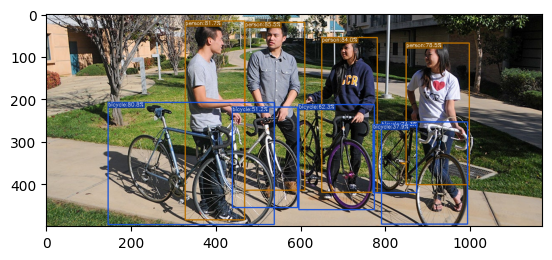

In [29]:
# Step 8. Process output

# Set a threshold for score confidence
score_thr = 0.3

# Set the path for output image
output_path = "test.jpg"

# Extract results from the model's output blob
res = res[out_blob]

# Post-process the output to get predictions
predictions = demo_postprocess(res, (h, w))[0]

# Extract bounding boxes and scores from the predictions
boxes = predictions[:, :4]
scores = predictions[:, 4, None] * predictions[:, 5:]

# Convert the bounding boxes from (x_center, y_center, width, height)
# to (x1, y1, x2, y2) format
boxes_xyxy = np.ones_like(boxes)
boxes_xyxy[:, 0] = boxes[:, 0] - boxes[:, 2]/2.
boxes_xyxy[:, 1] = boxes[:, 1] - boxes[:, 3]/2.
boxes_xyxy[:, 2] = boxes[:, 0] + boxes[:, 2]/2.
boxes_xyxy[:, 3] = boxes[:, 1] + boxes[:, 3]/2.

# Convert the bounding box coordinates to the original image size
boxes_xyxy /= ratio

# Apply Non-Maximum Suppression (NMS) to get the final detections
dets = multiclass_nms(boxes_xyxy, scores, nms_thr=0.45, score_thr=0.1)

# If there are any detections above the confidence threshold
if dets is not None:

    # Get the final bounding boxes, scores, and class indices
    final_boxes = dets[:, :4]
    final_scores, final_cls_inds = dets[:, 4], dets[:, 5]
    # Visualize the bounding boxes on the original image
    detecetd_img = vis(img=origin_img, boxes=final_boxes,
                       scores=final_scores, cls_ids=final_cls_inds,
                       conf=score_thr, class_names=COCO_CLASSES)

# Save the image with bounding boxes drawn on it
cv2.imwrite(output_path, detecetd_img)

plt.imshow(detecetd_img[:, :, ::-1])
